This notebook organizes all the results in the "analysis" folder within a concrete storyline

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is converted to HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [2]:
%load_ext autoreload
%autoreload 1
%aimport utils_read_parsing
from utils_read_parsing import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
from patsy import dmatrices
# from scipy.stats import ranksums
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
# from statsmodels.graphics.api import interaction_plot, abline_plot
# from statsmodels.stats.anova import anova_lm
from statsmodels.discrete.discrete_model import Logit

%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 7, 4
pd.set_option('precision',3)
pd.set_option("display.width", 100)
pd.set_option("max.columns", 100)
np.set_printoptions(precision=3,suppress=True)

# Preparing the data
Once we load all the data in a table, it will look like this:

**Note**: there are a few data transformations we still want to make, see section on *Massaging data*

In [3]:
t = [['sid','sim','variable','pre','main','CVS_table','CVS_graph','tansfer_qual','tansfer_quant','attributes']]
t.append(['12345678','C','Width',1,2,1,1,1,0,'...'])
t.append(['12345678','C','Concentration',2,3,1,1,1,1,'...'])
t.append(['12345678','C','Area',1,2,1,0,1,0,'...'])
print tabulate(t)

--------  ---  -------------  ---  ----  ---------  ---------  ------------  -------------  ----------
sid       sim  variable       pre  main  CVS_table  CVS_graph  tansfer_qual  tansfer_quant  attributes
12345678  C    Width          1    2     1          1          1             0              ...
12345678  C    Concentration  2    3     1          1          1             1              ...
12345678  C    Area           1    2     1          0          1             0              ...
--------  ---  -------------  ---  ----  ---------  ---------  ------------  -------------  ----------


## Defining important variables

In [4]:
ids = get_students_to_analyze_log()
N = len(ids)
print "There are {0} students to analyze.".format(N)

There are 148 students to analyze.


In [5]:
variables = ["Area","Separation","Width","Concentration"]
print "We are analyzing student knowledge and modeling of these variables: {0}.".format(', '.join(variables))

We are analyzing student knowledge and modeling of these variables: Area, Separation, Width, Concentration.


In [6]:
merged = True
number_of_trials = 3
if merged:
    print '''We will be analyzing cvs where table_consecutive and table_non_consecutive are merged
        and CVS is detected for {0} minimum trials.'''.format(number_of_trials)
else:
    print '''We will be analyzing cvs where table_consecutive and table_non_consecutive are NOT merged
        and CVS is detected for {0} minimum trials.'''.format(number_of_trials)

We will be analyzing cvs where table_consecutive and table_non_consecutive are merged
        and CVS is detected for 3 minimum trials.


## Loading all student data files

In [7]:
%reload_ext utils_read_parsing
meta_df = get_student_metadata()
pre_survey_df = get_massaged_pre_survey()
post_survey_df = get_massaged_post_survey()
attitudes_df = get_incoming_attitudes()
worksheet_df = get_massaged_worksheet_highest_understanding_data()
cvs_df = get_cvs_results(number_of_trials,merged=merged)
transfer_df = get_massaged_near_transfer_data()
wrapper_use_df = get_use_wrapper_results().rename(columns={'studentid':'sid'})

In [8]:
#We only keep the worksheet data,CVS and transfer data for the variables we care about
worksheet_df = worksheet_df[worksheet_df['variable'].isin(variables)]
cvs_df = cvs_df[cvs_df['variable'].isin(variables)]
transfer_df = transfer_df[transfer_df['variable'].isin(variables)]

Here are the dataframes and their sizes:

In [9]:
print "meta", meta_df.shape
print "pre_survey", pre_survey_df.shape
print "post_survey", post_survey_df.shape
print "worksheet", worksheet_df.shape
print "cvs", cvs_df.shape
print "transfer", transfer_df.shape
print "wrapper_use", wrapper_use_df.shape

meta (180, 23)
pre_survey (148, 24)
post_survey (296, 70)
worksheet (592, 5)
cvs (592, 3)
transfer (592, 4)
wrapper_use (148, 7)


## Putting it all together
The worksheet dataframe is the most complex with 1 row for each combination of sid * variable * model so we merge other data onto it.

In [10]:
data = worksheet_df.copy()
data = data.merge(cvs_df, how='outer', on=['sid','variable']);
data = data.merge(transfer_df, how='outer', on=['sid','variable']);
data = data.merge(wrapper_use_df, how='outer', on=['sid']);

In [11]:
## We add the student activity order
order = dict(zip(meta_df.index,meta_df['activity order']))
data['activity_order'] = data.sid.apply(lambda sid: order[sid])
data['sim_index'] = data.apply(lambda row: row['activity_order'].index(row['sim'])+1,axis=1)

We would like to use following student attributes from pre surveys in our stats models:
* level of physics and chemistry lab experience
* level of virtual lab experience
* if they have used a similar sim before
* perception of competence and control
* task interpretation
* perceived value

In [12]:
student_data_L = pd.DataFrame({'sid':ids,'sim':'L','similar_sim':0})
student_data_C = pd.DataFrame({'sid':ids,'sim':'C','similar_sim':0})

pre_survey_df['similar_same_L'] = (pre_survey_df['similar_L'] + pre_survey_df['same_L']).replace(2,1)
pre_survey_df['similar_same_C'] = (pre_survey_df['similar_C'] + pre_survey_df['same_C']).replace(2,1)

similar_same_L = dict(zip(pre_survey_df['sid'],pre_survey_df['similar_same_L']))
similar_same_C = dict(zip(pre_survey_df['sid'],pre_survey_df['similar_same_C']))

student_data_L['similar_sim'] = student_data_L['sid'].apply(lambda sid: similar_same_L[sid])
student_data_C['similar_sim'] = student_data_C['sid'].apply(lambda sid: similar_same_C[sid])

student_data = pd.concat([student_data_L,student_data_C],axis=0).reset_index(drop=True)

In [13]:
lab_columns = ['[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate physics laboratory]','[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate chemistry laboratory]','[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [Higher level chemistry labs]']
pre_survey_df['lab_experience'] = pre_survey_df[lab_columns].fillna(0).sum(axis=1).replace(3,1).replace(2,1)
student_data = student_data.merge(pre_survey_df[['sid','lab_experience','prior_number_virtual_labs']], how="inner", on=['sid']);
student_data = student_data.merge(attitudes_df, how="inner", on=['sid']);

In [14]:
data = data.merge(student_data, how="inner", on = ['sid','sim'])

And here is what are data for 1 student looks like:

In [15]:
data.sort_values(['sid','variable']).reset_index(drop=True).head(4)

,sid,variable,pre_highest,sim,main_highest,CVS_context,qual_score,quant_score,use_table,use_graph,use_concentration,use_width,use_area,use_separation,activity_order,sim_index,similar_sim,lab_experience,prior_number_virtual_labs,overall POCC,PC1,PC2
0,10127163,Area,3.0,C,3.0,2,1.0,1.0,1,1,1,1,1,1,LC,2,0,1.0,1,17,-0.509,0.152
1,10127163,Concentration,1.0,L,3.0,2,1.0,1.0,1,1,1,1,1,1,LC,1,0,1.0,1,17,-0.509,0.152
2,10127163,Separation,3.0,C,3.0,2,1.0,1.0,1,1,1,1,1,1,LC,2,0,1.0,1,17,-0.509,0.152
3,10127163,Width,1.0,L,3.0,2,1.0,1.0,1,1,1,1,1,1,LC,1,0,1.0,1,17,-0.509,0.152


## Massaging data for stats models
1. We remove the student who didn't engage with the charge sim (**from all analysis???**)
* we don't care about "identify" so we turn scores of:
    * 0->0 (all incorrect)
    * 1->0 (identify merged with incorrect)
    * 2->1 (qual)
    * 3->2 (quant).
* We split CVS_context to graph and table

In [16]:
data['use_all_vars'] = data['use_concentration'] + data['use_width'] + data['use_area'] + data['use_separation']
for student_to_remove in list(set(data[data['use_all_vars']<4]['sid'])):
    data = data[data['sid']!=student_to_remove];
M = len(set(data['sid']))
print "After removing {0} student who didn't engage with all variables, we are left with {1} students to analyze".format(N-M,M)
N = M

After removing 1 student who didn't engage with all variables, we are left with 147 students to analyze


In [17]:
data['pre'] = data['pre_highest'].replace(1,0).replace(2,1).replace(3,2)
data['main'] = data['main_highest'].replace(1,0).replace(2,1).replace(3,2)
data.rename({'pre_highest':'pre_with_ident','main_highest':'main_with_ident'},inplace=True,axis=1)

In [18]:
data['cvs_graph'] = data['CVS_context'].replace(1,0).replace(2,1)
data['cvs_table'] = data['CVS_context'].replace(2,1)

In [19]:
data = data[['sid','sim','variable','pre','main','cvs_graph','cvs_table','qual_score','quant_score','activity_order','sim_index','similar_sim','lab_experience','prior_number_virtual_labs','overall POCC','PC1','PC2','pre_with_ident','main_with_ident','CVS_context','use_table','use_graph','use_concentration','use_width','use_area','use_separation','use_all_vars']]

Now our data for 1 student looks like:

In [20]:
data.head(4)

,sid,sim,variable,pre,main,cvs_graph,cvs_table,qual_score,quant_score,activity_order,sim_index,similar_sim,lab_experience,prior_number_virtual_labs,overall POCC,PC1,PC2,pre_with_ident,main_with_ident,CVS_context,use_table,use_graph,use_concentration,use_width,use_area,use_separation,use_all_vars
0,10127163,L,Concentration,0.0,2.0,1,1,1.0,1.0,LC,1,0,1.0,1,17,-0.509,0.152,1.0,3.0,2,1,1,1,1,1,1,4
1,10127163,L,Width,0.0,2.0,1,1,1.0,1.0,LC,1,0,1.0,1,17,-0.509,0.152,1.0,3.0,2,1,1,1,1,1,1,4
2,10127163,C,Area,2.0,2.0,1,1,1.0,1.0,LC,2,0,1.0,1,17,-0.509,0.152,3.0,3.0,2,1,1,1,1,1,1,4
3,10127163,C,Separation,2.0,2.0,1,1,1.0,1.0,LC,2,0,1.0,1,17,-0.509,0.152,3.0,3.0,2,1,1,1,1,1,1,4


## Exporting the data

In [21]:
export_data = data.copy()
export_data.to_csv(os.path.join(BIG_FOLDER,'all_massaged_data\\dataframe_all_factors_for_analysis.txt'), sep='\t', index=False)

## Stats tools

In [22]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

def clean_summary(model):
    m = model.summary()
    lines = m.as_text().split('\n')
    lines = [l for l in lines if 'C(sid)' not in l]
    return '\n'.join(lines)

# Results to present in methods
## Student population

In [23]:
genders = ['gender-Gender non conforming/non-binary','gender-Man','gender-Prefer not to answer','gender-Woman']
t = [['Gender identity','Number of students','Percentage']]
for g in genders:
    t.append([g, len(set(post_survey_df[post_survey_df[g]==1]['sid'])), round(len(set(post_survey_df[post_survey_df[g]==1]['sid']))/float(N)*100,1)])
print tabulate(t)

---------------------------------------  ------------------  ----------
Gender identity                          Number of students  Percentage
gender-Gender non conforming/non-binary  1                   0.7
gender-Man                               50                  34.0
gender-Prefer not to answer              1                   0.7
gender-Woman                             96                  65.3
---------------------------------------  ------------------  ----------


In [24]:
years = ['year-1st year undergraduate','year-2nd year undergraduate','year-3rd year undergraduate','year-4th year undergraduate']
t = [['Year','Number of students','Percentage']]
for year in years:
    t.append([year, len(set(post_survey_df[post_survey_df[year]==1]['sid'])), round(len(set(post_survey_df[post_survey_df[year]==1]['sid']))/float(N)*100,1)])
print tabulate(t)

---------------------------  ------------------  ----------
Year                         Number of students  Percentage
year-1st year undergraduate  112                 76.2
year-2nd year undergraduate  22                  15.0
year-3rd year undergraduate  11                  7.5
year-4th year undergraduate  4                   2.7
---------------------------  ------------------  ----------


In [25]:
print "English writing fluency"
post_survey_df['english.0-writing'].value_counts()

English writing fluency


Fluent      134
Average      13
Beginner      1
Name: english.0-writing, dtype: int64

In [26]:
print "English reading fluency"
post_survey_df['english.1-reading'].value_counts()

English reading fluency


Fluent     137
Average     11
Name: english.1-reading, dtype: int64

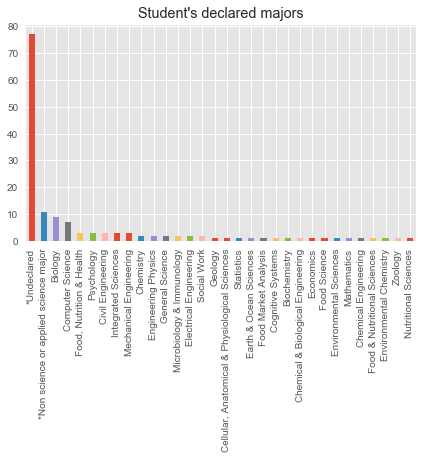

In [27]:
post_survey_df['major'].value_counts().plot.bar()
plt.title('Student\'s declared majors');

## Student prior experience

In [28]:
print "{0} ({1}%) of students have prior physics or chemistry experience.".format(len(set(data[data['lab_experience']==1]['sid'])), round(float(len(set(data[data['lab_experience']==1]['sid'])))/float(N),3)*100)
print "{0} ({1}%) of students have prior experience with the same or a similar sim as the Light absorbance sim.".format(len(set(data[(data['sim']=='L')&(data['similar_sim']==1)]['sid'])), round(float(len(set(data[(data['sim']=='L')&(data['similar_sim']==1)]['sid'])))/float(N),3)*100)
print "{0} ({1}%) of students have prior experience with the same or a similar sim as the Charge sim.".format(len(set(data[(data['sim']=='C')&(data['similar_sim']==1)]['sid'])), round(float(len(set(data[(data['sim']=='C')&(data['similar_sim']==1)]['sid'])))/float(N),3)*100)

132 (89.8%) of students have prior physics or chemistry experience.
55 (37.4%) of students have prior experience with the same or a similar sim as the Light absorbance sim.
16 (10.9%) of students have prior experience with the same or a similar sim as the Charge sim.


In [29]:
priors = list(set(data['prior_number_virtual_labs']))
t = [['Number of prior virtual labs','Number of students','Percentage']]
for prior in priors:
    t.append([prior, len(set(data[data['prior_number_virtual_labs']==prior]['sid'])), round(len(set(data[data['prior_number_virtual_labs']==prior]['sid']))/float(N)*100,1)])
print tabulate(t)
print '''where number corresponds to the following options in the survey:
 0 -> None
 1 -> 1-2 (roughly)
 2 -> 3-5 (roughly)
 3 -> 6+ (roughly)'''

----------------------------  ------------------  ----------
Number of prior virtual labs  Number of students  Percentage
0                             14                  9.5
1                             38                  25.9
2                             55                  37.4
3                             40                  27.2
----------------------------  ------------------  ----------
where number corresponds to the following options in the survey:
 0 -> None
 1 -> 1-2 (roughly)
 2 -> 3-5 (roughly)
 3 -> 6+ (roughly)


In [30]:
print "In terms of activity order, {0} students do LC and {1} students in CL".format(len(set(data[data['activity_order']=='LC']['sid'])),len(set(data[data['activity_order']=='CL']['sid'])))

In terms of activity order, 76 students do LC and 71 students in CL


## Defining incoming attitude factors
See the notebook "incoming_attributes_analysis.ipynb" for data and viz on that.

# Results section
## Descriptives

### Learning through inquiry

Let's look at pre to post to see if students learn.

D:\Applications\Anaconda2\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


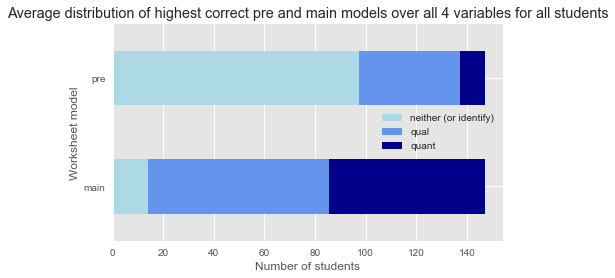

In [31]:
table = data.melt(value_vars=['pre','main'],id_vars=['variable'],var_name='type')
(table.groupby(['type','value']).count().unstack()/len(variables)).plot.barh(stacked=True,colors=['lightblue','cornflowerblue','darkblue'])
plt.legend(['neither (or identify)','qual','quant'])
plt.xlabel("Number of students")
plt.ylabel("Worksheet model")
plt.title("Average distribution of highest correct pre and main models over all {0} variables for all students".format(len(variables)));

### Use of CVS and thus how to define it.
See viz on usage of CVS for different minimum variables and with table_consecutive and table_non_consecutive merged in the notebook *comparing_cvs_usage.ipynb*.

### CVS and pre to main model scores, by variable

In [32]:
# table = data.melt(value_vars=['pre','main'],id_vars=['sid','variable','CVS_context'],var_name='type')
# table = table.groupby(['CVS_context','variable','type','value']).count()

# fig,axes = plt.subplots(nrows=3,ncols=4,figsize=(15,4))
# for j,var in enumerate(variables):
#     for i,cvs in enumerate([0,1,2]):
#         ax=axes[i,j]
#         subdata = table.loc[(cvs,var)]
#         N_CVS = subdata['sid'].sum()
#         subdata['precent students'] = subdata['sid']/N_CVS*2*100
#         subdata['precent students'].unstack().plot.barh(ax=ax,colors=['lightblue','cornflowerblue','darkblue'],stacked=True)
#         if i==0:
#             ax.set(title=var)
#         if j==0:
#             ax.set(ylabel={0:"none",1:"table",2:"graph"}[cvs])
#         else:
#             ax.set(ylabel='')
#         if i<2:
#             ax.set(xticklabels = [])
#         if i==2:
#             ax.set(xlabel='Percent of students')
#         ax.set(xlim=(0,100))
#         ax.legend([])
# plt.suptitle('Percentage of students with correct quant (dark blue), qual (medium blue) or neither (light blue) given the type of CVS done per variable', fontsize=16)

In [33]:
CMAP = ['#fc8d62','cornflowerblue','darkblue']

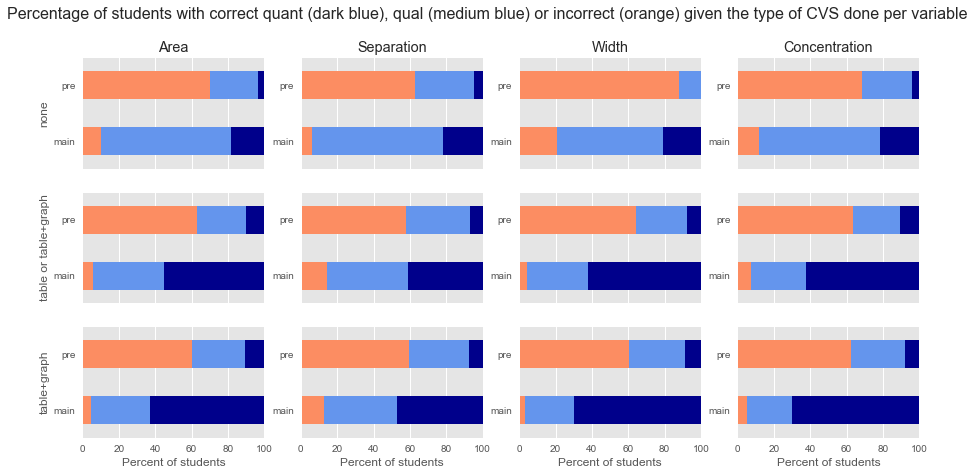

In [34]:
table = data.melt(value_vars=['pre','main'],id_vars=['sid','variable','cvs_table','cvs_graph'],var_name='type')

fig,axes = plt.subplots(nrows=3,ncols=4,figsize=(15,7))
for j,var in enumerate(variables):
    for i,cvs in enumerate([0,'cvs_table','cvs_graph']):
        ax=axes[i,j]
        if cvs==0:
            subdata = table.groupby(['cvs_table','variable','type','value']).count().loc[(0,var)]
        else:
            subdata = table.groupby([cvs,'variable','type','value']).count().loc[(1,var)]
        N_CVS = subdata['sid'].sum()
        subdata['precent students'] = subdata['sid']/N_CVS*2*100
        subdata['precent students'].unstack().plot.barh(ax=ax,colors=CMAP,stacked=True)
        if i==0:
            ax.set(title=var)
        if j==0:
            ax.set(ylabel={0:"none","cvs_table":"table or table+graph","cvs_graph":"table+graph"}[cvs])
        else:
            ax.set(ylabel='')
        if i<2:
            ax.set(xticklabels = [])
        if i==2:
            ax.set(xlabel='Percent of students')
        ax.set(xlim=(0,100))
        ax.legend([])
plt.suptitle('Percentage of students with correct quant (dark blue), qual (medium blue) or incorrect (orange) given the type of CVS done per variable', fontsize=16)

Since the above graphs show proportions fo students per model type, we cannot assess how many students are in each viz (i.e. how many students did cvs for table for the variable Separation). We redo the same graphs with number of students instead of proportions:

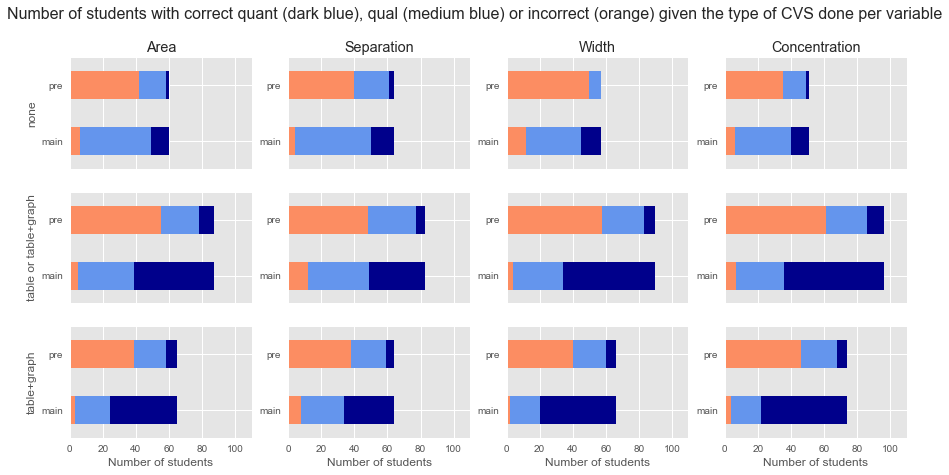

In [35]:
table = data.melt(value_vars=['pre','main'],id_vars=['sid','variable','cvs_table','cvs_graph'],var_name='type')

fig,axes = plt.subplots(nrows=3,ncols=4,figsize=(15,7))
for j,var in enumerate(variables):
    for i,cvs in enumerate([0,'cvs_table','cvs_graph']):
        ax=axes[i,j]
        if cvs==0:
            subdata = table.groupby(['cvs_table','variable','type','value']).count().loc[(0,var)]
        else:
            subdata = table.groupby([cvs,'variable','type','value']).count().loc[(1,var)]
        N_CVS = subdata['sid'].sum()
        subdata['number students'] = subdata['sid']#/N_CVS*2*100
        subdata['number students'].unstack().plot.barh(ax=ax,colors=CMAP,stacked=True)
        if i==0:
            ax.set(title=var)
        if j==0:
            ax.set(ylabel={0:"none","cvs_table":"table or table+graph","cvs_graph":"table+graph"}[cvs])
        else:
            ax.set(ylabel='')
        if i<2:
            ax.set(xticklabels = [])
        if i==2:
            ax.set(xlabel='Number of students')
        ax.set(xlim=(0,110))
        ax.legend([])
plt.suptitle('Number of students with correct quant (dark blue), qual (medium blue) or incorrect (orange) given the type of CVS done per variable', fontsize=16)

There are several things to notice:
* For each variable, about 50-60 students don't do CVS.
* The odd of doing different CVS or not doesn't change much by variable
* We can see that the profile of pre models doesn't change much by variable nor by what CVS was done.
* Most students do cvs_table
* Doing cvs_table clearly helps a little to get a quantitative model (slightly less for Separation).
* Doing cvs_graph clearly helps a lot (slightly less for Separation).

### Transfer items

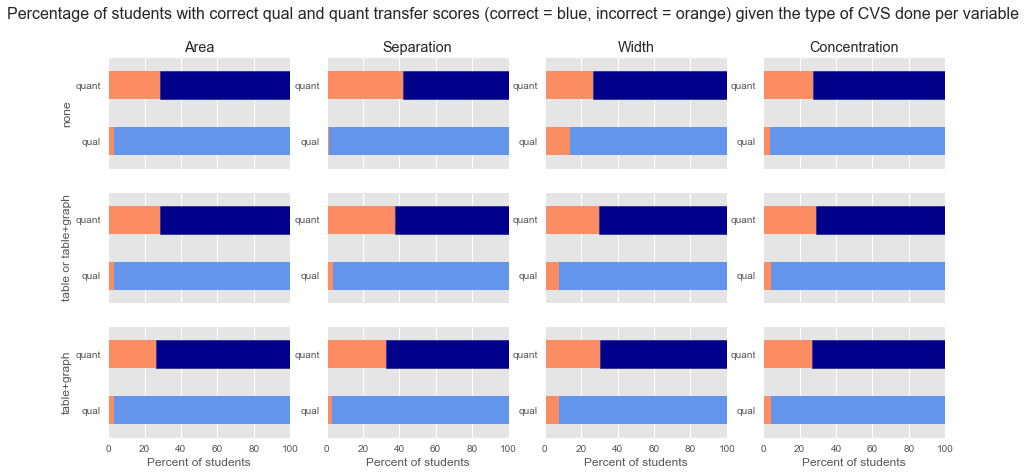

In [36]:
table = data.melt(value_vars=['qual_score','quant_score'],id_vars=['sid','variable','cvs_table','cvs_graph'],var_name='type')

fig,axes = plt.subplots(nrows=3,ncols=4,figsize=(15,7))
for j,var in enumerate(variables):
    for i,cvs in enumerate([0,'cvs_table','cvs_graph']):
        ax=axes[i,j]
        if cvs==0:
            subdata = table.groupby(['cvs_table','variable','type','value']).count().loc[(0,var)]
        else:
            subdata = table.groupby([cvs,'variable','type','value']).count().loc[(1,var)]
        N_CVS = subdata['sid'].sum()
        subdata['precent students'] = subdata['sid']/N_CVS*2*100
        subdata['precent students'].unstack().plot.barh(ax=ax,colors=CMAP,stacked=True)
        if i==0:
            ax.set(title=var)
        if j==0:
            ax.set(ylabel={0:"none","cvs_table":"table or table+graph","cvs_graph":"table+graph"}[cvs])
        else:
            ax.set(ylabel='')
        if i<2:
            ax.set(xticklabels = [])
        if i==2:
            ax.set(xlabel='Percent of students')
        ax.set(yticklabels = ['qual','quant'])
        ax.set(xlim=(0,100))
        ax.legend([])
        bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
        bars[3].set_color(CMAP[2])
plt.suptitle('Percentage of students with correct qual and quant transfer scores (correct = blue, incorrect = orange) given the type of CVS done per variable', fontsize=16)


We notice the following:
* Qual trasnfer items are near ceiling. Only the variable "Width" gets 5-15% of students confused, perhaps for the same reason many students have an incorrect pre model for Width (because of the confusion between absorbance and transmission).
* Quant transfer increase slightly when students to CVS but by no more than 5%. Thus we do not expect our stats models to have CVS as a significant variable.

## Stats model 1 post-hocs

### post-hoc for cvs_table


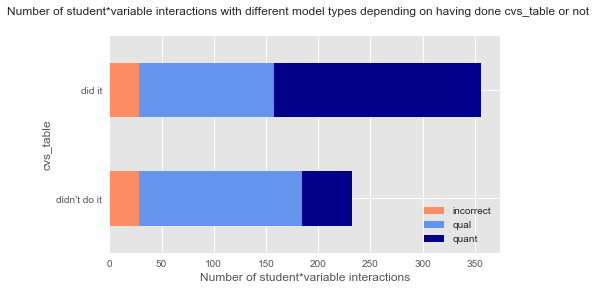

In [37]:
fig,ax = plt.subplots(nrows=1,ncols=1)
data.groupby(['cvs_table','main']).count()['sid'].unstack().plot.barh(stacked=True,colors=CMAP,ax=ax)
ax.set(xlabel='Number of student*variable interactions')
ax.set(yticklabels = ['didn\'t do it', 'did it'])
ax.legend(['incorrect','qual','quant'])
# bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
# bars[3].set_color(CMAP[2])
plt.suptitle('Number of student*variable interactions with different model types depending on having done cvs_table or not')

### post-hoc for cvs_graph

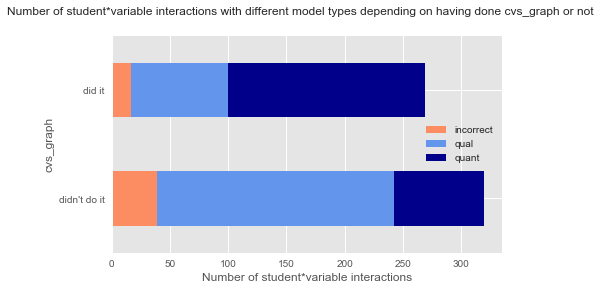

In [38]:
fig,ax = plt.subplots(nrows=1,ncols=1)
data.groupby(['cvs_graph','main']).count()['sid'].unstack().plot.barh(stacked=True,colors=CMAP,ax=ax)
ax.set(xlabel='Number of student*variable interactions')
ax.set(yticklabels = ['didn\'t do it', 'did it'])
ax.legend(['incorrect','qual','quant'])
# bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
# bars[3].set_color(CMAP[2])
plt.suptitle('Number of student*variable interactions with different model types depending on having done cvs_graph or not')

### post-hoc for sim_index

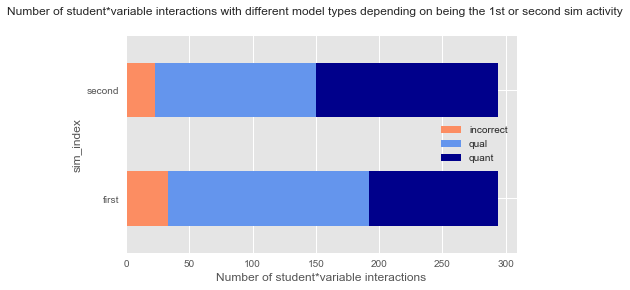

In [39]:
fig,ax = plt.subplots(nrows=1,ncols=1)
data.groupby(['sim_index','main']).count()['sid'].unstack().plot.barh(stacked=True,colors=CMAP,ax=ax)
ax.set(xlabel='Number of student*variable interactions')
ax.set(yticklabels = ['first','second'])
ax.legend(['incorrect','qual','quant'])
# bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
# bars[3].set_color(CMAP[2])
plt.suptitle('Number of student*variable interactions with different model types depending on being the 1st or second sim activity')

## Post-hoc by variable

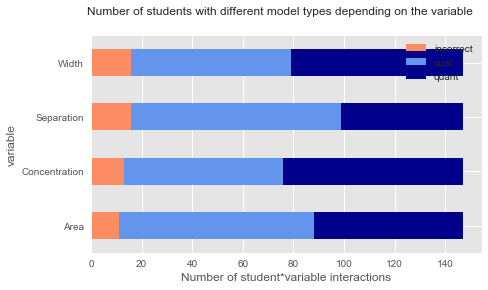

In [40]:
fig,ax = plt.subplots(nrows=1,ncols=1)
data.groupby(['variable','main']).count()['sid'].unstack().plot.barh(stacked=True,colors=CMAP,ax=ax)
ax.set(xlabel='Number of student*variable interactions')
ax.legend(['incorrect','qual','quant'])
# bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
# bars[3].set_color(CMAP[2])
plt.suptitle('Number of students with different model types depending on the variable')

## Stats model 2 post-hocs

### post-hoc for variable

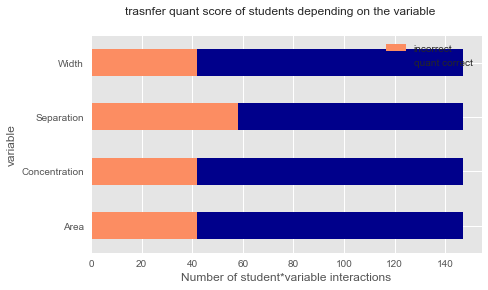

In [41]:
fig,ax = plt.subplots(nrows=1,ncols=1)
data.groupby(['variable','quant_score']).count()['sid'].unstack().plot.barh(stacked=True,colors=[CMAP[0],CMAP[2]],ax=ax)
ax.set(xlabel='Number of student*variable interactions')
ax.legend(['incorrect','quant correct'])
# bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
# bars[3].set_color(CMAP[2])
plt.suptitle('trasnfer quant score of students depending on the variable')

### post-hoc for similar_sim

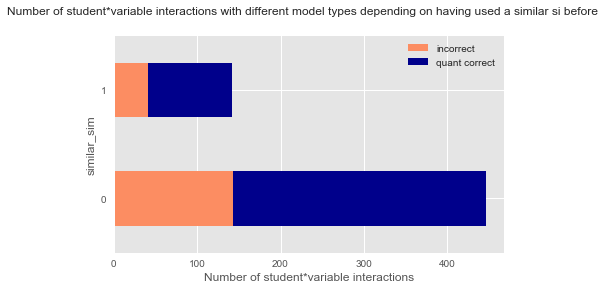

In [42]:
fig,ax = plt.subplots(nrows=1,ncols=1)
data.groupby(['similar_sim','quant_score']).count()['sid'].unstack().plot.barh(stacked=True,colors=[CMAP[0],CMAP[2]],ax=ax)
ax.set(xlabel='Number of student*variable interactions')
ax.legend(['incorrect','quant correct'])
# bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
# bars[3].set_color(CMAP[2])
plt.suptitle('Number of student*variable interactions with different model types depending on having used a similar si before')

## Stats model 3 post-hocs

### Post-hoc for sim_index

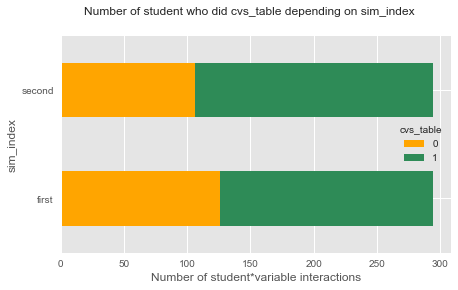

In [43]:
fig,ax = plt.subplots(nrows=1,ncols=1)
data.groupby(['sim_index','cvs_table']).count()['sid'].unstack().plot.barh(stacked=True,colors=['orange','seagreen'],ax=ax)
ax.set(xlabel='Number of student*variable interactions')
ax.set(yticklabels = ['first','second'])
# ax.legend(['incorrect','qual','quant'])
# bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
# bars[3].set_color(CMAP[2])
plt.suptitle('Number of student who did cvs_table depending on sim_index')

## Post-hoc for lab experience

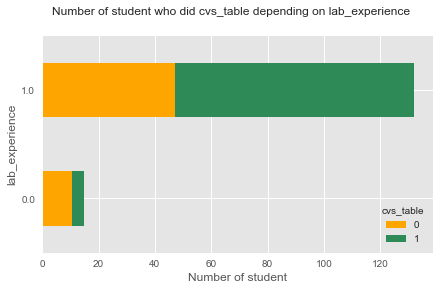

In [44]:
fig,ax = plt.subplots(nrows=1,ncols=1)
df = data.groupby(['lab_experience','cvs_table']).count()['sid'].unstack()/len(variables)
df.plot.barh(stacked=True,colors=['orange','seagreen'],ax=ax)
ax.set(xlabel='Number of student')
# ax.set(yticklabels = ['first','second'])
# ax.legend(['incorrect','qual','quant'])
# bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
# bars[3].set_color(CMAP[2])
plt.suptitle('Number of student who did cvs_table depending on lab_experience')

### post hoc for pre

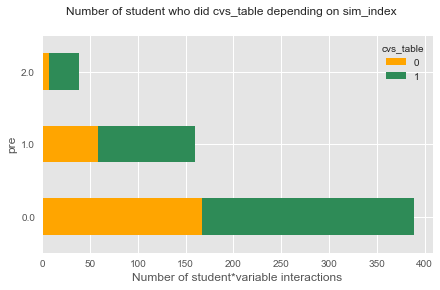

In [45]:
fig,ax = plt.subplots(nrows=1,ncols=1)
data.groupby(['pre','cvs_table']).count()['sid'].unstack().plot.barh(stacked=True,colors=['orange','seagreen'],ax=ax)
ax.set(xlabel='Number of student*variable interactions')
# ax.set(yticklabels = ['first','second'])
# ax.legend(['incorrect','qual','quant'])
# bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
# bars[3].set_color(CMAP[2])
plt.suptitle('Number of student who did cvs_table depending on sim_index')

### post hoc for PC2

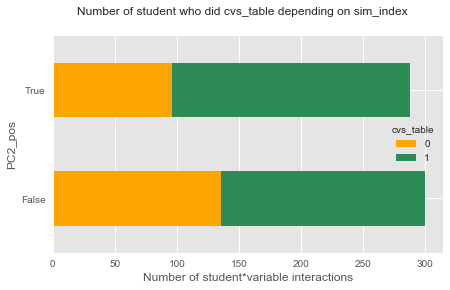

In [46]:
fig,ax = plt.subplots(nrows=1,ncols=1)
data['PC2_pos'] = (data['PC2']>0)
data.groupby(['PC2_pos','cvs_table']).count()['sid'].unstack().plot.barh(stacked=True,colors=['orange','seagreen'],ax=ax)
ax.set(xlabel='Number of student*variable interactions')
# ax.set(yticklabels = ['first','second'])
# ax.legend(['incorrect','qual','quant'])
# bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
# bars[3].set_color(CMAP[2])
plt.suptitle('Number of student who did cvs_table depending on sim_index')